In [1]:
%pip install pandas numpy matplotlib seaborn scipy scikit-learn tensorflow pillow

  Using cached matplotlib-3.9.1-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scipy-1.14.0-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached scikit_learn-1.5.1-cp310-cp310-win_amd64.whl.metadata (12 kB)
  Using cached contourpy-1.2.1-cp310-cp310-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.1-cp310-cp310-win_amd64.whl.metadata (165 kB)
  Using cached kiwisolver-1.4.5-cp310-cp310-win_amd64.whl.metadata (6.5 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached matplotlib-3.9.1-cp310-cp310-win_amd64.whl (8.0 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached scipy-1.14.0-cp310-cp310-win_amd64.whl (44.8 MB)
Using cached scikit_learn-1.5.1-cp310-cp31

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [3]:
def load_data(base_path):
    classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    data = []
    for cls in classes:
        metadata_file = os.path.join(base_path, f"{cls}.metadata.xlsx")
        print(f"Checking for metadata file: {metadata_file}")
        if not os.path.exists(metadata_file):
            print(f"Metadata file not found: {metadata_file}")
            continue
        try:
            metadata = pd.read_excel(metadata_file)
            print(f"Successfully read metadata for {cls}")
        except Exception as e:
            print(f"Error reading metadata for {cls}: {str(e)}")
            continue

        img_folder = os.path.join(base_path, cls)
        print(f"Checking image folder: {img_folder}")
        if not os.path.exists(img_folder):
            print(f"Image folder not found: {img_folder}")
            continue

        for _, row in metadata.iterrows():
            img_path = os.path.join(img_folder, "images", f"{row['FILE NAME']}.png")
            if os.path.exists(img_path):
                try:
                    with Image.open(img_path) as img:
                        # Convert image to RGB
                        img_rgb = img.convert('RGB')
                        # Resize image
                        img_resized = img_rgb.resize((224, 224))
                        # Convert to numpy array
                        img_array = np.array(img_resized)
                        data.append({
                            'image': img_array,
                            'label': cls,
                            'size': f"{img.width}x{img.height}",
                            'url': row['URL']
                        })
                except Exception as e:
                    print(f"Error processing image {img_path}: {str(e)}")
            else:
                print(f"Image not found: {img_path}")

    if not data:
        print("No data was loaded. Check the base path and file structure.")
    return pd.DataFrame(data)

In [4]:
# Load data
base_path = 'COVID-19_Radiography_Dataset'  # Update this path
data = load_data(base_path)

Checking for metadata file: COVID-19_Radiography_Dataset\COVID.metadata.xlsx
Successfully read metadata for COVID
Checking image folder: COVID-19_Radiography_Dataset\COVID
Checking for metadata file: COVID-19_Radiography_Dataset\Lung_Opacity.metadata.xlsx
Successfully read metadata for Lung_Opacity
Checking image folder: COVID-19_Radiography_Dataset\Lung_Opacity
Checking for metadata file: COVID-19_Radiography_Dataset\Normal.metadata.xlsx
Successfully read metadata for Normal
Checking image folder: COVID-19_Radiography_Dataset\Normal
Checking for metadata file: COVID-19_Radiography_Dataset\Viral Pneumonia.metadata.xlsx
Successfully read metadata for Viral Pneumonia
Checking image folder: COVID-19_Radiography_Dataset\Viral Pneumonia


In [5]:
# Save data to a CSV file
data.to_csv('covid_data.csv', index=False)

In [6]:
# EDA
print(data.info())
if not data.empty:
    print(data['label'].value_counts())
    print(f"Image dimensions: {data['size'].iloc[0]}")
else:
    print("DataFrame is empty. No data was loaded.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   21165 non-null  object
 1   label   21165 non-null  object
 2   size    21165 non-null  object
 3   url     21165 non-null  object
dtypes: object(4)
memory usage: 661.5+ KB
None
label
Normal             10192
Lung_Opacity        6012
COVID               3616
Viral Pneumonia     1345
Name: count, dtype: int64
Image dimensions: 299x299


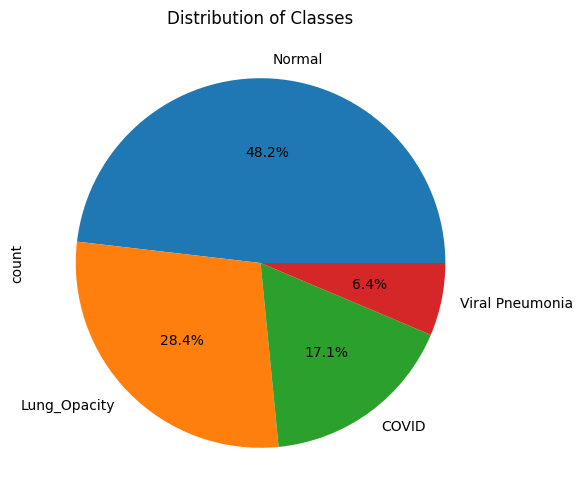

In [7]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
data['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Classes')
plt.show()

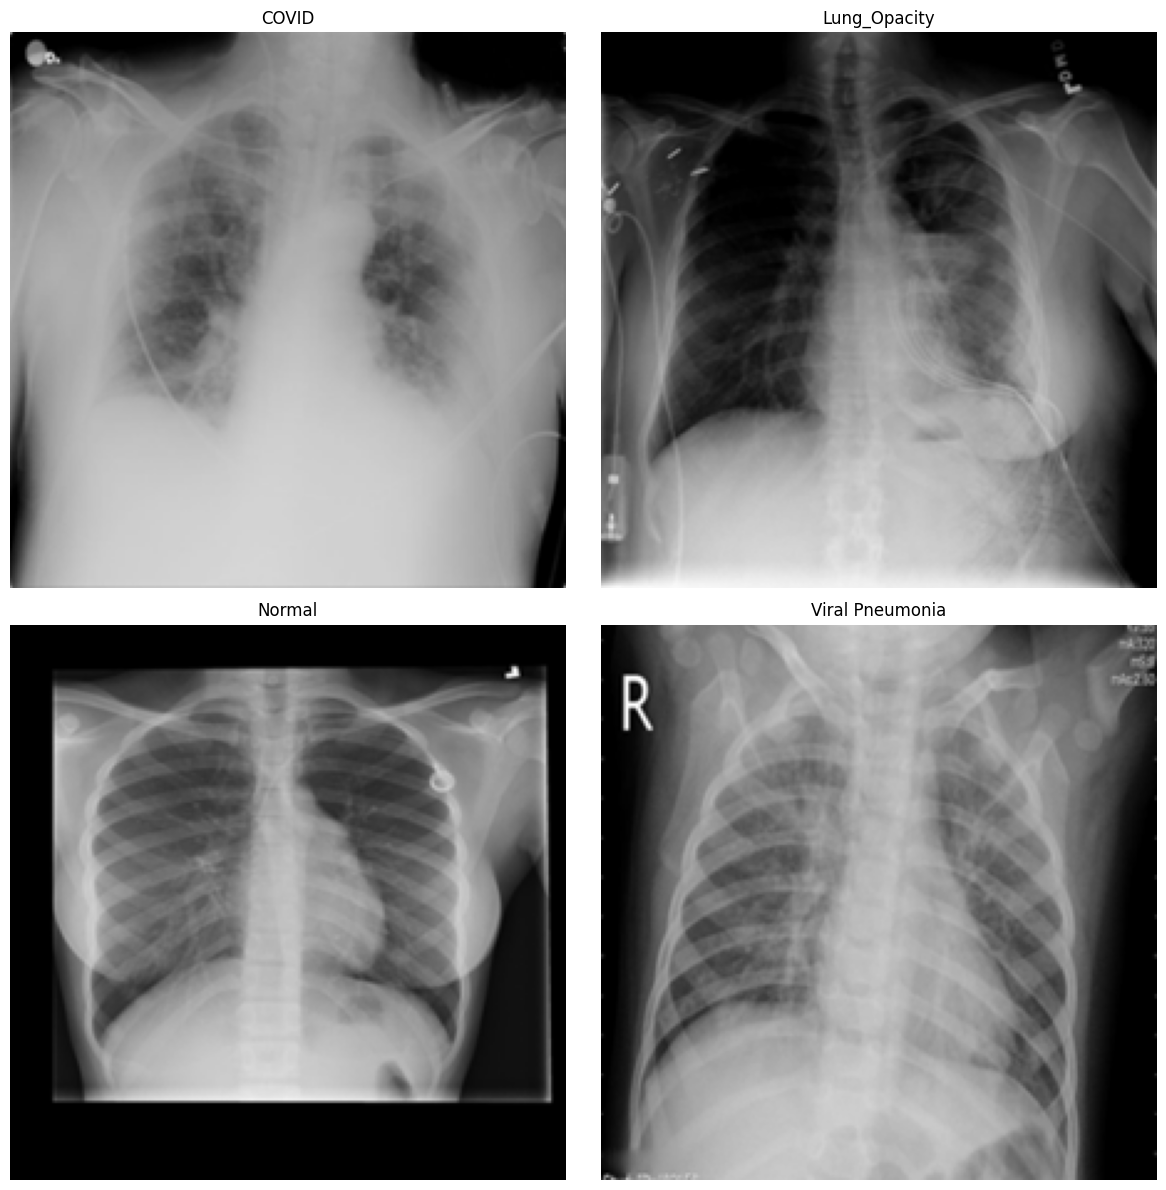

In [8]:
# Visualize sample images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i, label in enumerate(data['label'].unique()):
    img_array = data[data['label'] == label]['image'].iloc[0]
    axes[i//2, i%2].imshow(img_array)
    axes[i//2, i%2].set_title(label)
    axes[i//2, i%2].axis('off')
plt.tight_layout()
plt.show()

In [9]:
# Prepare data for CNN
X = np.array([d for d in data['image'].values])
y = pd.get_dummies(data['label']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (21165, 224, 224, 3)
y shape: (21165, 4)


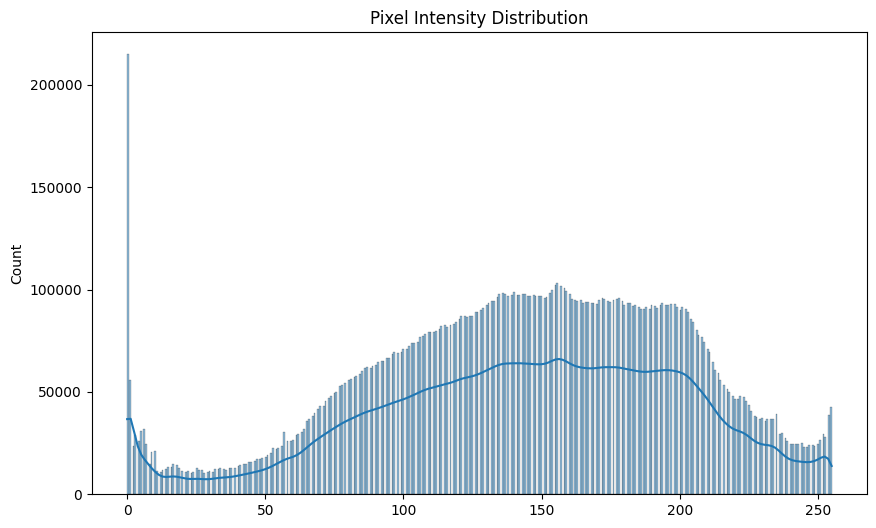

In [10]:
# Pixel intensity distribution
pixel_intensities = np.concatenate([img.flatten() for img in X[:100]])
plt.figure(figsize=(10, 6))
sns.histplot(pixel_intensities, kde=True)
plt.title('Pixel Intensity Distribution')
plt.show()

In [11]:
# Statistical Tests
def get_mean_intensity(image_array):
    return np.mean(image_array)

data['mean_intensity'] = data['image'].apply(get_mean_intensity)

In [12]:
# Perform t-tests between each pair of classes
classes = data['label'].unique()
for i in range(len(classes)):
    for j in range(i+1, len(classes)):
        class1 = data[data['label'] == classes[i]]['mean_intensity']
        class2 = data[data['label'] == classes[j]]['mean_intensity']
        t_stat, p_value = stats.ttest_ind(class1, class2)
        print(f"T-test ({classes[i]} vs {classes[j]}): t-statistic = {t_stat}, p-value = {p_value}")

T-test (COVID vs Lung_Opacity): t-statistic = 26.568255001147932, p-value = 3.746158596202895e-150
T-test (COVID vs Normal): t-statistic = 22.599900868785877, p-value = 4.4466575480330525e-111
T-test (COVID vs Viral Pneumonia): t-statistic = 18.82228426942629, p-value = 2.1587873696853873e-76
T-test (Lung_Opacity vs Normal): t-statistic = -9.039561286475344, p-value = 1.7474925089243124e-19
T-test (Lung_Opacity vs Viral Pneumonia): t-statistic = 0.9629183084634326, p-value = 0.33562017720244686
T-test (Normal vs Viral Pneumonia): t-statistic = 6.284487861614234, p-value = 3.407961881523202e-10


In [13]:
# ANOVA
f_statistic, p_value = stats.f_oneway(*[group['mean_intensity'].values for name, group in data.groupby('label')])
print(f"ANOVA: F-statistic = {f_statistic}, p-value = {p_value}")

ANOVA: F-statistic = 285.9122550028886, p-value = 6.041651088550714e-182


In [14]:
# CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes now
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

c:\Users\dharm\OneDrive\Desktop\Voolt\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 148s 344ms/step - accuracy: 0.5529 - loss: 57.1210 - val_accuracy: 0.6581 - val_loss: 0.7941
Epoch 2/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 140s 330ms/step - accuracy: 0.7326 - loss: 0.6637 - val_accuracy: 0.7366 - val_loss: 0.7144
Epoch 3/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 141s 332ms/step - accuracy: 0.8306 - loss: 0.4510 - val_accuracy: 0.7635 - val_loss: 0.6171
Epoch 4/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 140s 330ms/step - accuracy: 0.8898 - loss: 0.2961 - val_accuracy: 0.7679 - val_loss: 0.7075
Epoch 5/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 142s 334ms/step - accuracy: 0.9279 - loss: 0.1977 - val_accuracy: 0.7762 - val_loss: 0.8391
Epoch 6/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 143s 338ms/step - accuracy: 0.9559 - loss: 0.1219 - val_accuracy: 0.7635 - val_loss: 0.9144
Epoch 7/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 141s 333ms/step - accuracy: 0.9666 - loss: 0.0996 - val_accuracy: 0.7724 - val_loss: 1.0827
Epoch 8/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 141s 332ms/step - accuracy: 0.9837 

In [15]:
# Save the model
model.save('covid_classification_model.h5')
print("Model saved as 'covid_classification_model.h5'")

Model saved as 'covid_classification_model.h5'


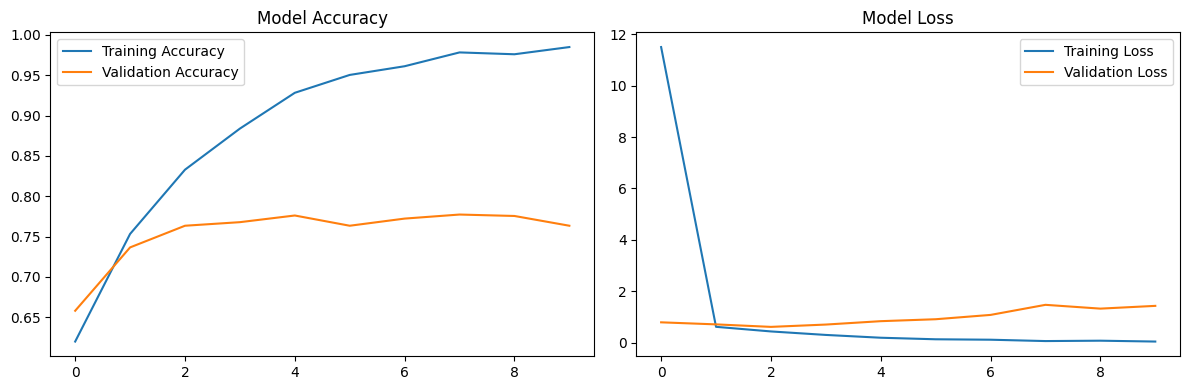

In [16]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

133/133 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - accuracy: 0.7770 - loss: 1.3889
Test Accuracy: 0.7791164517402649
133/133 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step


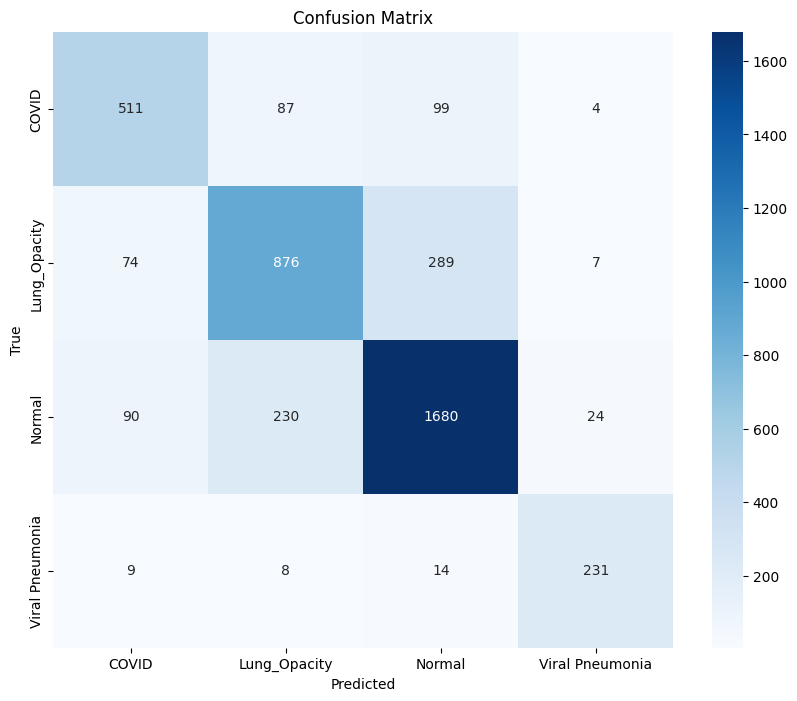

In [17]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=data['label'].unique(), 
            yticklabels=data['label'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()